In [39]:
import numpy as np
import numpy.testing as npt
import seaborn as sns
%matplotlib inline

There are 2K tables!
Dice rolls are distributed as a multinomial (aka categorical) distribution.
Each player visits K tables. So the number of timesteps in the model is equal to the number of tables. Use a list of vectors to hold the dice rolls. A set of observations for a single player is a vector containing the sums of their dice rolls at each table. The overall observation set will be a vector of vectors containing the set of observations for each player per vector.

In [40]:
#global state

num_players = 10
K = 1000
num_tables = 2*K
die_sides = 6
timesteps = K

In [41]:
# class Player:
#     def __init__(self):
        

# Generate Distributions

Setting up the emission matrix, seen in https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm

In [55]:
pval_uniform = np.array([1/float(die_sides)] * die_sides)
pval_goodbias = np.array([0.02, 0.02, 0.2, 0.2, 0.2, 0.36])
pval_badbias = np.array([0.3, 0.3, 0.1, 0.1, 0.1, 0.1])

emission_matrix = np.vstack([pval_uniform, pval_goodbias, pval_badbias])
print(emission_matrix)
print(emission_matrix.shape)
pval_player_bias = pval_uniform
npt.assert_almost_equal(np.sum(pval_uniform), 1)
npt.assert_almost_equal(np.sum(pval_badbias), 1)
npt.assert_almost_equal(np.sum(pval_goodbias), 1)


transition_matrix = np.array([[0.25, 0.75],
                              [0.75, 0.25]])

states = ('regular', 'primed')

start_probability = [1.0, 0]

[[ 0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667]
 [ 0.02        0.02        0.2         0.2         0.2         0.36      ]
 [ 0.3         0.3         0.1         0.1         0.1         0.1       ]]
(3, 6)


# Roll some dice!

Loop through 1 to K

For each step, use a function to return a distribution.

Roll a dice using the distribution as the tables distribution. Roll a dice using the player distribution. Sum it up, and put it in a vector.

In [43]:
def dice_roll(distribution):
    return np.random.choice([1,2,3,4,5,6], 1, True, distribution)

In [44]:
def visit_tables(emission_matrix, transition_matrix, table_dist_index, tableprime_dist_index, player_dice_dist):
    current_table = 0 #0 for table, 1 for table_prime
    player_rolls = np.zeros(K)
    table_rolls = np.zeros(K)
    dice_sums = np.zeros(K)
    for i in range(K):
        dice_dist = np.random.choice([table_dist_index,tableprime_dist_index], 1, True, transition_matrix[current_table,:])
        table_rolls[i] = dice_roll(emission_matrix[dice_dist[0],:])
        player_rolls[i] = dice_roll(emission_matrix[player_dice_dist,:]) 
        dice_sums[i] = table_rolls[i] + player_rolls[i]
    return dice_sums

# What if all of the dice are uniform?

In [45]:
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 0,0,0)
    

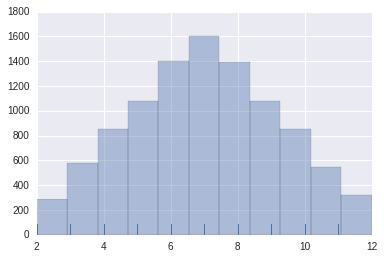

In [46]:
sns.distplot(np.concatenate(overall_observations),bins=11, kde=False, rug=True)

# What if all the dice are uniform except one?

In [47]:
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 0,1,0)

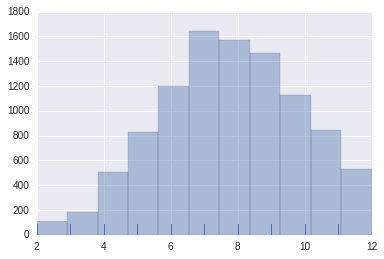

In [48]:
sns.distplot(np.concatenate(overall_observations),bins=11, kde=False, rug=True)

# What if all are bad/biased?
We'll give the table a good bias, and the player a bad bias



In [49]:
overall_observations = np.zeros((num_players, K))
for player in range(num_players):
    overall_observations[player] = visit_tables(emission_matrix, transition_matrix, 0,1,2) #player gets the bad bias

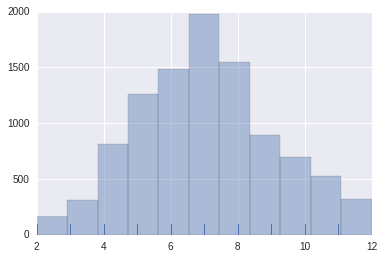

In [50]:
sns.distplot(np.concatenate(overall_observations),bins=11, kde=False, rug=True)

# Forward Algorithm

In [78]:
def fwd(observations, hidden_states, init_state, transition_matrix, emission_matrix):
    L = len(observations)
    fwd = []
    f_prev = []
    for i, x_i in enumerate(observations):
        f_curr = np.zeros(len(hidden_states))
        for state, _ in enumerate(hidden_states):
            if i == 0:
                prev_f_sum = init_state[state]
                print("Prev_f_sum: " + str(prev_f_sum))
            else:
                print("fix me")
            f_curr[state] = emission_matrix[state][x_i] * prev_f_sum
                

In [79]:
#test out the forward algorithm
fwd(overall_observations[0,:], states, start_probability, transition_matrix, emission_matrix)

Prev_f_sum: 1.0


/home/jonas/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: index 8 is out of bounds for axis 0 with size 6